Train Regime Statistics (mean and std of next-day return):


,AvgNextReturn,StdNextReturn,count
regime,,,
0,0.000096,0.010532,528
1,-0.000668,0.006343,627
2,0.000517,0.015905,307
3,-0.000169,0.007457,624
4,0.000597,0.009175,169
5,0.003508,0.027673,43
6,0.000404,0.009174,202


In-sample GMM regime prediction accuracy: 0.8000
=== Performance Metrics on Test Period (RF-based Regime) ===


,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
Multi-Regime-RF (Train2500),0.1706,0.0551,0.1470,0.3748,-0.2305
Buy-and-Hold,-0.0218,0.0049,0.1493,0.0331,-0.2532


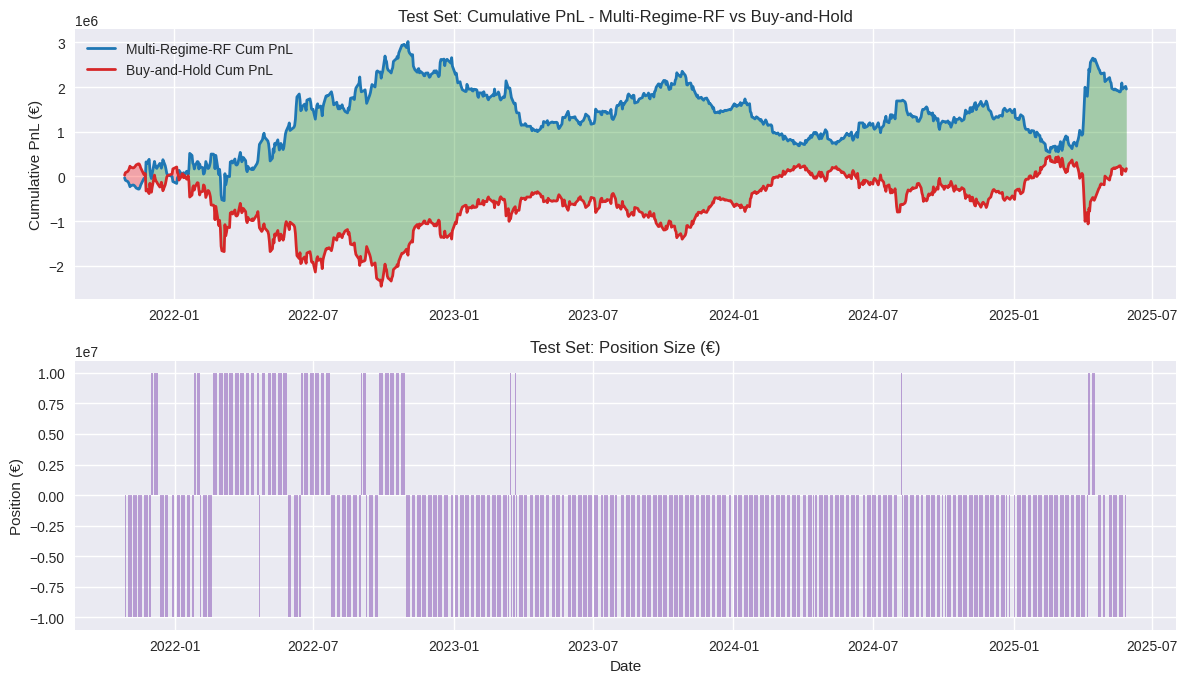

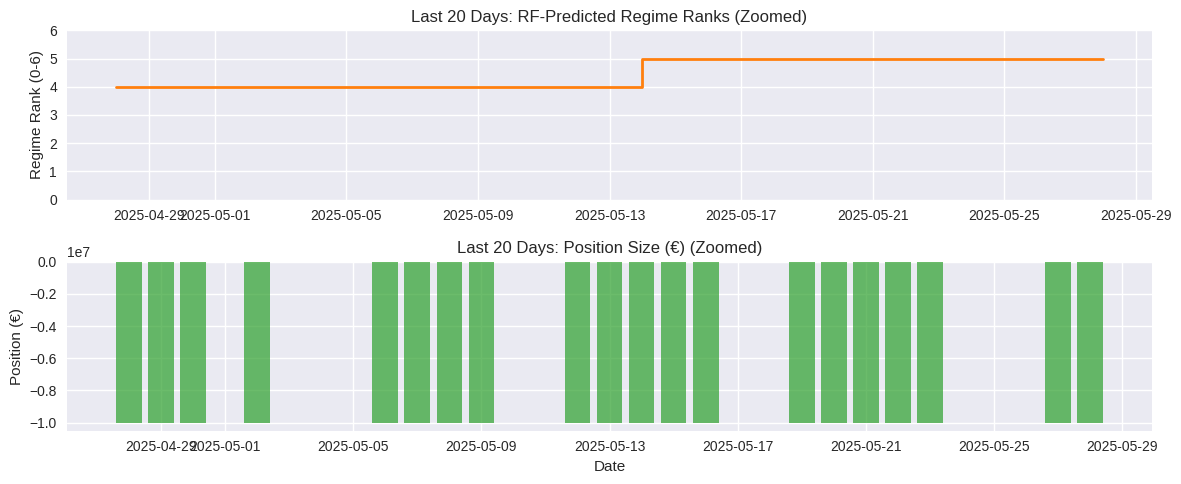

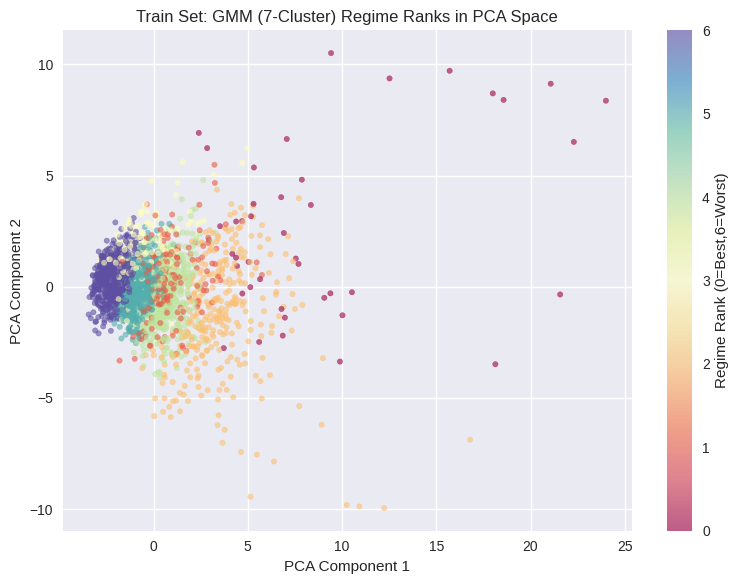

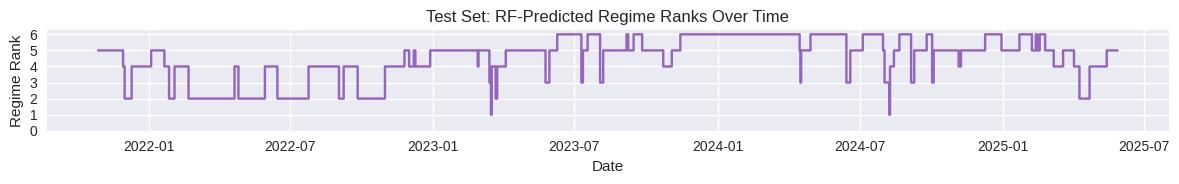

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# =============================================================================
# SUPERVISED REGIME IDENTIFICATION USING ALL EXPLANATORY FEATURES
# (GMM clustering on first 2500 train -> RF classifier on train -> apply to test)
# Extended to 7 regimes with added graphs
# =============================================================================

# 1) LOAD & CLEAN DATA
file_path = 'Project_RAMA2.xlsx'
df_raw = pd.read_excel(file_path, sheet_name='Processed2')

# Drop columns that are entirely NaN
df = df_raw.dropna(axis=1, how='all').copy()

# Sort by date ascending
df = df.sort_values('date').reset_index(drop=True)

# Compute next-day SX5E return (decimal)
df['next_return'] = df['sx5e_move'].shift(-1) / 100.0

# Drop final row (no next_return)
df = df.dropna(subset=['next_return']).reset_index(drop=True)

# Reconstruct price for reference
df['price'] = np.nan
df.loc[0, 'price'] = 100.0
for i in range(1, len(df)):
    df.loc[i, 'price'] = df.loc[i-1, 'price'] * (1 + df.loc[i-1, 'next_return'])

# 2) PREPARE EXPLANATORY FEATURES
exclude_cols = ['date', 'target', 'next_return', 'price', 'sx5e_move']
feature_cols = [c for c in df.columns if c not in exclude_cols]

# Drop rows with any NaNs in explanatory features
df_feat = df.dropna(subset=feature_cols).reset_index(drop=True)

# 3) SPLIT INTO TRAIN (first 2500) AND TEST (remaining)
train_size = 2500
if df_feat.shape[0] < train_size + 1:
    raise ValueError("Not enough rows after dropping NaNs to split 2500 train + test.")

train_df = df_feat.iloc[:train_size].reset_index(drop=True)
test_df  = df_feat.iloc[train_size:].reset_index(drop=True)

# 4) SCALE FEATURES BASED ON TRAIN
scaler = StandardScaler().fit(train_df[feature_cols])
X_train = scaler.transform(train_df[feature_cols])
X_test  = scaler.transform(test_df[feature_cols])

# 5) FIT GMM WITH 7 COMPONENTS ON TRAIN
n_regimes = 7
gmm = GaussianMixture(n_components=n_regimes, covariance_type='full', random_state=42)
gmm.fit(X_train)

# Assign regimes
train_df['regime'] = gmm.predict(X_train)
test_df['regime_gmm'] = gmm.predict(X_test)

# 6) RANK REGIMES BY TRAIN AVERAGE RETURN
regime_stats = (
    train_df
    .groupby('regime')['next_return']
    .agg(['mean', 'std', 'count'])
    .rename(columns={'mean': 'AvgNextReturn', 'std': 'StdNextReturn'})
)
print("Train Regime Statistics (mean and std of next-day return):")
display(regime_stats)

# Sort regimes descending by AvgNextReturn → map to rank 0..6
regime_order = regime_stats['AvgNextReturn'].sort_values(ascending=False).index.tolist()
regime_rank_map = {regime: rank for rank, regime in enumerate(regime_order)}

train_df['regime_rank'] = train_df['regime'].map(regime_rank_map)
test_df['regime_rank_gmm'] = test_df['regime_gmm'].map(regime_rank_map)

# 7) TRAIN RANDOM FOREST TO PREDICT GMM REGIME LABELS
rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
rf.fit(X_train, train_df['regime'])

# Evaluate in-sample accuracy
train_pred = rf.predict(X_train)
train_acc = accuracy_score(train_df['regime'], train_pred)
print(f"In-sample GMM regime prediction accuracy: {train_acc:.4f}")

# 8) PREDICT REGIME ON TEST USING RF
test_df['regime_rf'] = rf.predict(X_test)
test_df['regime_rank_rf'] = test_df['regime_rf'].map(regime_rank_map)

# 9) BUILD MULTI-REGIME SIGNAL ON TEST USING RF-PREDICTED RANKS
# Map: ranks {0,1,2} → long; {4,5,6} → short; rank 3 → flat
test_df['prev_return'] = test_df['next_return'].shift(1).fillna(0)

signals = np.zeros(len(test_df), dtype=int)
for i in range(len(test_df)):
    r = test_df.loc[i, 'regime_rank_rf']
    if r in [0, 1, 2]:
        signals[i] = 1
    elif r in [4, 5, 6]:
        signals[i] = -1
    else:
        signals[i] = 0

test_df['signal_multi_regime_rf'] = signals

# 10) COMPUTE POSITION SIZE AND BACKTEST ON TEST SET vs BUY-AND-HOLD
test_df['position_size'] = test_df['signal_multi_regime_rf'] * 10_000_000

test_df['pnl_multi_regime_rf'] = test_df['position_size'] * test_df['next_return']
test_df['cum_pnl_multi_regime_rf'] = np.cumsum(test_df['pnl_multi_regime_rf'])

test_df['pnl_bh'] = 10_000_000 * test_df['next_return']
test_df['cum_pnl_bh'] = np.cumsum(test_df['pnl_bh'])

# 11) PERFORMANCE METRICS ON TEST
def compute_metrics(pnl):
    daily_ret = pnl / 10_000_000
    wealth = (1 + daily_ret).cumprod()
    total_ret = wealth.iloc[-1] - 1
    avg_dr = daily_ret.mean()
    std_dr = daily_ret.std(ddof=1)
    ann_ret = avg_dr * 252
    ann_vol = std_dr * np.sqrt(252)
    sharpe = (avg_dr / std_dr) * np.sqrt(252) if std_dr != 0 else np.nan
    running_max = wealth.cummax()
    drawdown = wealth / running_max - 1
    max_dd = drawdown.min()
    return {
        'Total Return':           total_ret,
        'Annualized Return':      ann_ret,
        'Annualized Volatility':  ann_vol,
        'Sharpe Ratio':           sharpe,
        'Max Drawdown':           max_dd
    }

metrics_multi_rf = compute_metrics(test_df['pnl_multi_regime_rf'])
metrics_bh = compute_metrics(test_df['pnl_bh'])
metrics_compare = pd.DataFrame({
    'Multi-Regime-RF (Train2500)': metrics_multi_rf,
    'Buy-and-Hold':                 metrics_bh
}).T

print("=== Performance Metrics on Test Period (RF-based Regime) ===")
display(metrics_compare.style.format("{:.4f}"))

# 12) PLOT CUMULATIVE PnL AND POSITION SIZE OVER TEST
plt.figure(figsize=(12, 7))
dates_test = pd.to_datetime(test_df['date'])

cum_multi = test_df['cum_pnl_multi_regime_rf'].values.astype(float)
cum_bh = test_df['cum_pnl_bh'].values.astype(float)
pos_size = test_df['position_size'].values.astype(float)

# Cumulative PnL Plot
plt.subplot(2, 1, 1)
plt.plot(dates_test, cum_multi,
         label='Multi-Regime-RF Cum PnL', color='tab:blue', linewidth=2)
plt.plot(dates_test, cum_bh,
         label='Buy-and-Hold Cum PnL', color='tab:red', linewidth=2)
plt.fill_between(dates_test, cum_multi, cum_bh,
                 where=(cum_multi > cum_bh),
                 color='green', alpha=0.3)
plt.fill_between(dates_test, cum_multi, cum_bh,
                 where=(cum_multi <= cum_bh),
                 color='red', alpha=0.3)
plt.title('Test Set: Cumulative PnL - Multi-Regime-RF vs Buy-and-Hold')
plt.ylabel('Cumulative PnL (€)')
plt.legend(loc='upper left')
plt.grid(True)

# Position Size Plot
plt.subplot(2, 1, 2)
plt.bar(dates_test, pos_size, width=1.0, color='tab:purple', alpha=0.6)
plt.title('Test Set: Position Size (€)')
plt.xlabel('Date')
plt.ylabel('Position (€)')
plt.grid(True)

plt.tight_layout()
plt.show()

# 13) ZOOM ON LAST 20 TEST DAYS: Regime Rank and Position
zoom_df = test_df.iloc[-20:].reset_index(drop=True)
dates_zoom = pd.to_datetime(zoom_df['date'])

plt.figure(figsize=(12, 5))

# Regime Rank subplot
plt.subplot(2, 1, 1)
plt.plot(dates_zoom, zoom_df['regime_rank_rf'], drawstyle='steps-post', color='tab:orange', linewidth=2)
plt.title('Last 20 Days: RF-Predicted Regime Ranks (Zoomed)')
plt.ylabel('Regime Rank (0-6)')
plt.yticks(list(range(7)))
plt.grid(True)

# Position Size subplot
plt.subplot(2, 1, 2)
plt.bar(dates_zoom, zoom_df['position_size'], width=0.8, color='tab:green', alpha=0.7)
plt.title('Last 20 Days: Position Size (€) (Zoomed)')
plt.xlabel('Date')
plt.ylabel('Position (€)')
plt.grid(True)

plt.tight_layout()
plt.show()

# 14) PCA SCATTER OF TRAIN REGIMES (for context)
pca = PCA(n_components=2)
X_pca_train = pca.fit_transform(X_train)
df_pca_train = pd.DataFrame({
    'PC1': X_pca_train[:, 0],
    'PC2': X_pca_train[:, 1],
    'RegimeRank': train_df['regime_rank']
})

plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_train['PC1'], df_pca_train['PC2'],
                      c=df_pca_train['RegimeRank'], cmap='Spectral', s=15, alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Train Set: GMM (7-Cluster) Regime Ranks in PCA Space')
cbar = plt.colorbar(scatter, ticks=list(range(7)))
cbar.set_label('Regime Rank (0=Best,6=Worst)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 15) TIME SERIES OF TEST REGIME RANKS
plt.figure(figsize=(12, 2))
plt.plot(dates_test, test_df['regime_rank_rf'], drawstyle='steps-post', color='tab:purple')
plt.xlabel('Date')
plt.ylabel('Regime Rank')
plt.yticks(list(range(7)), [str(i) for i in range(7)])
plt.title('Test Set: RF-Predicted Regime Ranks Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()



=== Performance vs Number of Regimes ===


,AdaptiveTotalReturn,AdaptiveSharpe,AdaptiveMaxDrawdown,BHTotalReturn,BHSharpe,BHMaxDrawdown
NumRegimes,,,,,,
3,0.1690,0.4408,-0.1366,-0.0218,0.0331,-0.2532
5,0.0241,0.1177,-0.1945,-0.0218,0.0331,-0.2532
6,0.0152,0.1027,-0.2351,-0.0218,0.0331,-0.2532
7,0.1706,0.3748,-0.2305,-0.0218,0.0331,-0.2532
8,-0.0388,-0.0002,-0.2288,-0.0218,0.0331,-0.2532


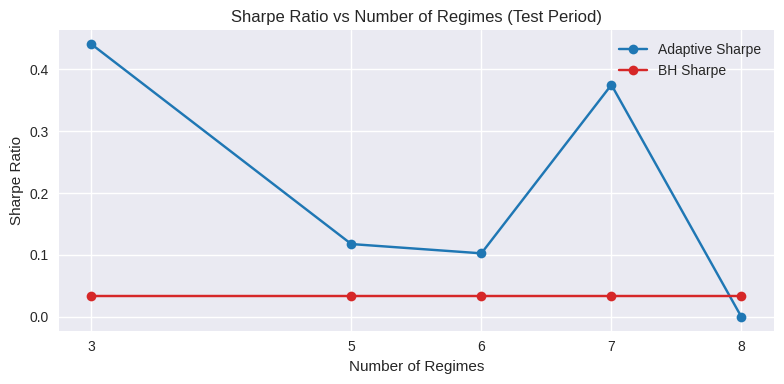

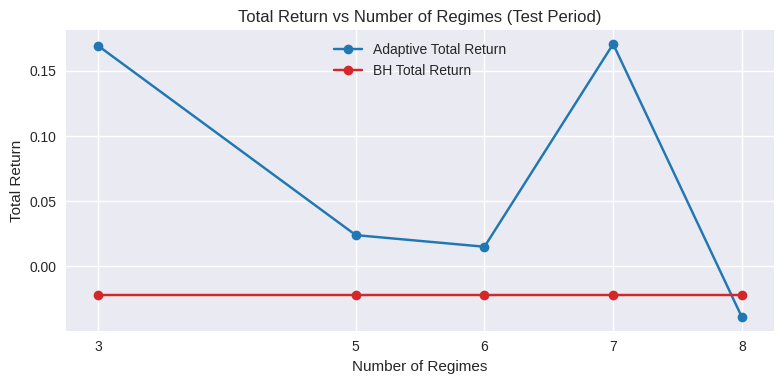

In [53]:
# =============================================================================
# PERFORMANCE VS NUMBER OF REGIMES (3, 5, 6, 7, 8)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1) LOAD & CLEAN DATA
file_path = 'Project_RAMA2.xlsx'
df_raw = pd.read_excel(file_path, sheet_name='Processed2')

# Drop columns that are entirely NaN
df = df_raw.dropna(axis=1, how='all').copy()

# Sort by date ascending
df = df.sort_values('date').reset_index(drop=True)

# Compute next-day SX5E return (decimal)
df['next_return'] = df['sx5e_move'].shift(-1) / 100.0

# Drop final row (no next_return)
df = df.dropna(subset=['next_return']).reset_index(drop=True)

# Reconstruct price (not used in clustering)
df['price'] = np.nan
df.loc[0, 'price'] = 100.0
for i in range(1, len(df)):
    df.loc[i, 'price'] = df.loc[i-1, 'price'] * (1 + df.loc[i-1, 'next_return'])

# 2) PREPARE EXPLANATORY FEATURES
exclude_cols = ['date', 'target', 'next_return', 'price', 'sx5e_move']
feature_cols = [c for c in df.columns if c not in exclude_cols]
df_feat = df.dropna(subset=feature_cols).reset_index(drop=True)

# 3) SPLIT INTO TRAIN (first 2500) AND TEST (remaining)
train_size = 2500
train_df = df_feat.iloc[:train_size].reset_index(drop=True)
test_df  = df_feat.iloc[train_size:].reset_index(drop=True)

# 4) SCALE FEATURES BASED ON TRAIN
scaler = StandardScaler().fit(train_df[feature_cols])
X_train = scaler.transform(train_df[feature_cols])
X_test  = scaler.transform(test_df[feature_cols])

# 5) PERFORMANCE METRICS FUNCTION
def compute_metrics(pnl_series):
    daily_ret = pnl_series / 10_000_000
    wealth = (1 + daily_ret).cumprod()
    total_ret = wealth.iloc[-1] - 1
    avg_dr = daily_ret.mean()
    std_dr = daily_ret.std(ddof=1)
    ann_ret = avg_dr * 252
    ann_vol = std_dr * np.sqrt(252)
    sharpe = (avg_dr / std_dr) * np.sqrt(252) if std_dr != 0 else np.nan
    running_max = wealth.cummax()
    drawdown = wealth / running_max - 1
    max_dd = drawdown.min()
    return total_ret, ann_ret, ann_vol, sharpe, max_dd

# 6) LOOP OVER DIFFERENT NUMBERS OF REGIMES
regime_list = [3, 5, 6, 7, 8]
results = []

for n_regimes in regime_list:
    # Fit GMM on train
    gmm = GaussianMixture(n_components=n_regimes, covariance_type='full', random_state=42)
    gmm.fit(X_train)

    # Assign regimes
    train_df['regime'] = gmm.predict(X_train)
    test_df['regime_gmm'] = gmm.predict(X_test)

    # Rank regimes by train average next_return
    regime_stats = train_df.groupby('regime')['next_return'].agg(['mean']).rename(columns={'mean': 'AvgNextReturn'})
    regime_order = regime_stats['AvgNextReturn'].sort_values(ascending=False).index.tolist()
    regime_rank_map = {regime: rank for rank, regime in enumerate(regime_order)}

    train_df['regime_rank'] = train_df['regime'].map(regime_rank_map)
    test_df['regime_rank_gmm'] = test_df['regime_gmm'].map(regime_rank_map)

    # Train RF on train regimes
    rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
    rf.fit(X_train, train_df['regime'])

    # Predict on test
    test_df['regime_rf'] = rf.predict(X_test)
    test_df['regime_rank_rf'] = test_df['regime_rf'].map(regime_rank_map)

    # Build adaptive signal: top half ranks → long, bottom half → short, middle (if any) → flat
    top_cut = n_regimes // 2
    bottom_cut = n_regimes - top_cut

    test_df['prev_return'] = test_df['next_return'].shift(1).fillna(0)
    signals = np.zeros(len(test_df), dtype=int)
    for i in range(len(test_df)):
        r = test_df.loc[i, 'regime_rank_rf']
        if r < top_cut:
            signals[i] = 1
        elif r >= bottom_cut:
            signals[i] = -1
        else:
            signals[i] = 0
    test_df['signal'] = signals

    # Compute adaptive PnL
    test_df['position'] = test_df['signal'] * 10_000_000
    test_df['pnl_adaptive'] = test_df['position'] * test_df['next_return']
    test_df['cum_pnl_adaptive'] = test_df['pnl_adaptive'].cumsum()

    # Buy and Hold PnL
    test_df['pnl_bh'] = 10_000_000 * test_df['next_return']
    test_df['cum_pnl_bh'] = test_df['pnl_bh'].cumsum()

    # Compute metrics for adaptive and BH
    a_total, a_ann, a_vol, a_sharpe, a_dd = compute_metrics(test_df['pnl_adaptive'])
    bh_total, bh_ann, bh_vol, bh_sharpe, bh_dd = compute_metrics(test_df['pnl_bh'])

    results.append({
        'NumRegimes': n_regimes,
        'AdaptiveTotalReturn': a_total,
        'AdaptiveSharpe': a_sharpe,
        'AdaptiveMaxDrawdown': a_dd,
        'BHTotalReturn': bh_total,
        'BHSharpe': bh_sharpe,
        'BHMaxDrawdown': bh_dd
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).set_index('NumRegimes')

# Display results
print("=== Performance vs Number of Regimes ===")
display(results_df.style.format({
    'AdaptiveTotalReturn': '{:.4f}',
    'AdaptiveSharpe': '{:.4f}',
    'AdaptiveMaxDrawdown': '{:.4f}',
    'BHTotalReturn': '{:.4f}',
    'BHSharpe': '{:.4f}',
    'BHMaxDrawdown': '{:.4f}'
}))

# Plot Sharpe vs Number of Regimes
plt.figure(figsize=(8, 4))
plt.plot(results_df.index, results_df['AdaptiveSharpe'], marker='o', label='Adaptive Sharpe', color='tab:blue')
plt.plot(results_df.index, results_df['BHSharpe'], marker='o', label='BH Sharpe', color='tab:red')
plt.xlabel('Number of Regimes')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio vs Number of Regimes (Test Period)')
plt.xticks(results_df.index)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Total Return vs Number of Regimes
plt.figure(figsize=(8, 4))
plt.plot(results_df.index, results_df['AdaptiveTotalReturn'], marker='o', label='Adaptive Total Return', color='tab:blue')
plt.plot(results_df.index, results_df['BHTotalReturn'], marker='o', label='BH Total Return', color='tab:red')
plt.xlabel('Number of Regimes')
plt.ylabel('Total Return')
plt.title('Total Return vs Number of Regimes (Test Period)')
plt.xticks(results_df.index)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Train Regime Statistics (mean and std of next-day return):


,AvgNextReturn,StdNextReturn,count
regime,,,
0,-0.000074,0.010341,330
1,-0.000413,0.008106,429
2,0.001477,0.014247,241


In-sample GMM regime prediction accuracy: 0.9690
=== Performance Metrics on Test Period (RF-based Regime, 3 Regimes) ===


,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
"Multi-Regime-RF (3 Regimes, Train2500)",0.4256,0.0467,0.1365,0.3418,-0.2633
Buy-and-Hold,-0.2070,-0.0124,0.1544,-0.0805,-0.4419


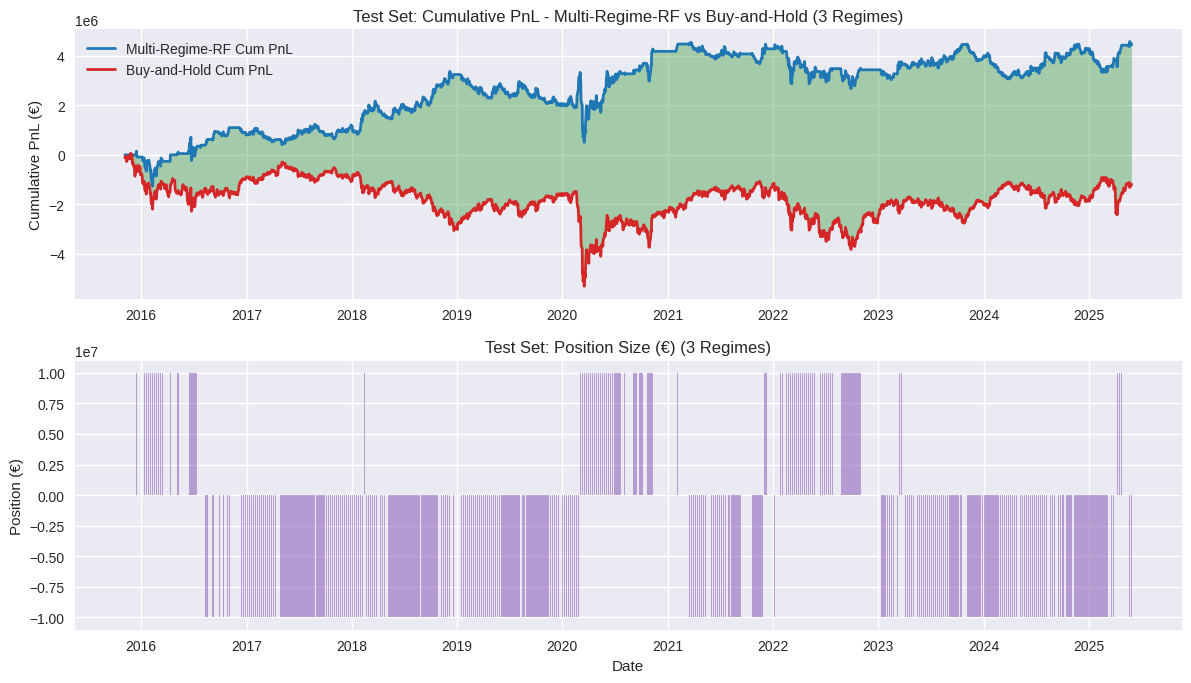

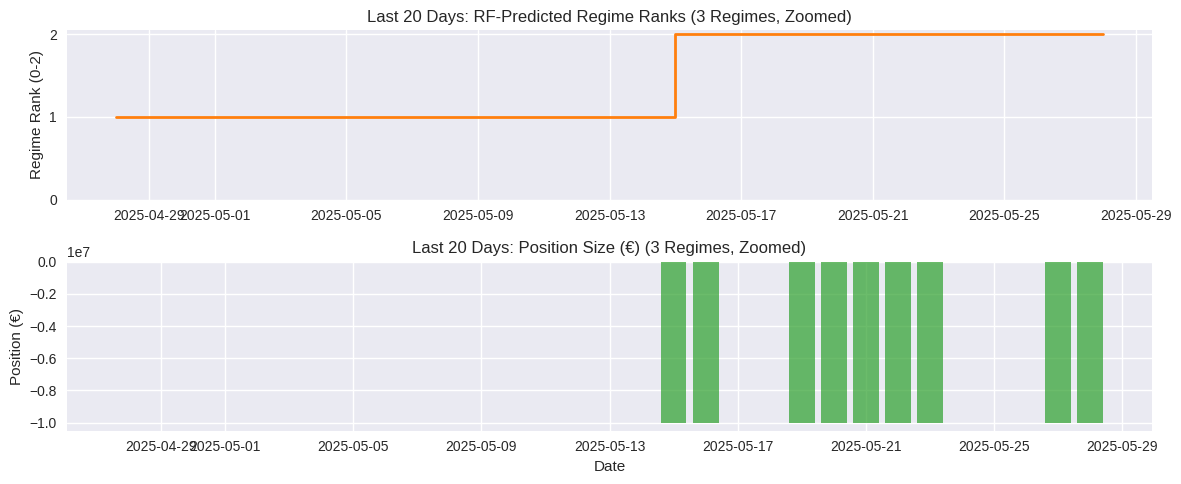

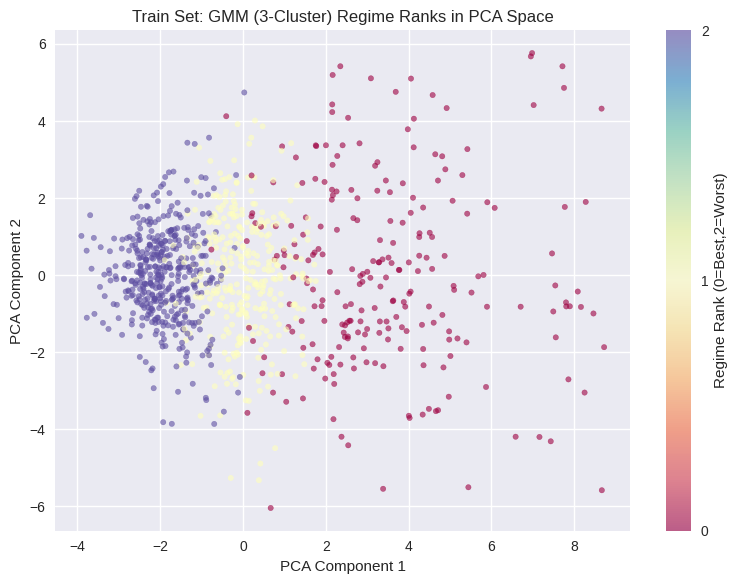

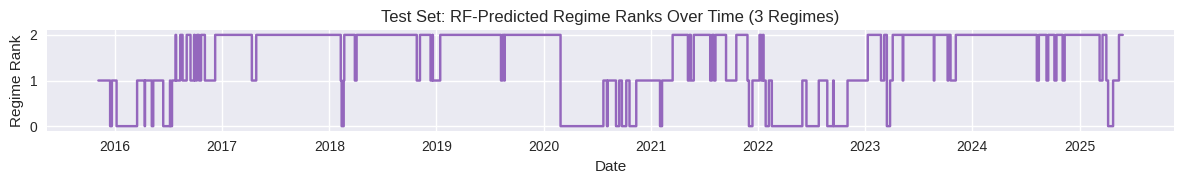

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# =============================================================================
# SUPERVISED REGIME IDENTIFICATION USING 3 REGIMES
# (GMM clustering on first 2500 train -> RF classifier on train -> apply to test)
# =============================================================================

# 1) LOAD & CLEAN DATA
file_path = 'Project_RAMA2.xlsx'
df_raw = pd.read_excel(file_path, sheet_name='Processed2')

# Drop columns that are entirely NaN
df = df_raw.dropna(axis=1, how='all').copy()

# Sort by date ascending
df = df.sort_values('date').reset_index(drop=True)

# Compute next-day SX5E return (decimal)
df['next_return'] = df['sx5e_move'].shift(-1) / 100.0

# Drop final row (no next_return)
df = df.dropna(subset=['next_return']).reset_index(drop=True)

# Reconstruct price for reference (not used in clustering)
df['price'] = np.nan
df.loc[0, 'price'] = 100.0
for i in range(1, len(df)):
    df.loc[i, 'price'] = df.loc[i-1, 'price'] * (1 + df.loc[i-1, 'next_return'])

# 2) PREPARE EXPLANATORY FEATURES
exclude_cols = ['date', 'target', 'next_return', 'price', 'sx5e_move']
feature_cols = [c for c in df.columns if c not in exclude_cols]

# Drop rows with any NaNs in explanatory features
df_feat = df.dropna(subset=feature_cols).reset_index(drop=True)

# 3) SPLIT INTO TRAIN (first 2500) AND TEST (remaining)
train_size = 2500
if df_feat.shape[0] < train_size + 1:
    raise ValueError("Not enough rows after dropping NaNs to split 2500 train + test.")

train_df = df_feat.iloc[:train_size].reset_index(drop=True)
test_df  = df_feat.iloc[train_size:].reset_index(drop=True)

# 4) SCALE FEATURES BASED ON TRAIN
scaler = StandardScaler().fit(train_df[feature_cols])
X_train = scaler.transform(train_df[feature_cols])
X_test  = scaler.transform(test_df[feature_cols])

# 5) FIT GMM WITH 3 COMPONENTS ON TRAIN
n_regimes = 3
gmm = GaussianMixture(n_components=n_regimes, covariance_type='full', random_state=42)
gmm.fit(X_train)

# Assign regimes
train_df['regime'] = gmm.predict(X_train)
test_df['regime_gmm'] = gmm.predict(X_test)

# 6) RANK REGIMES BY TRAIN AVERAGE RETURN
regime_stats = (
    train_df
    .groupby('regime')['next_return']
    .agg(['mean', 'std', 'count'])
    .rename(columns={'mean': 'AvgNextReturn', 'std': 'StdNextReturn'})
)
print("Train Regime Statistics (mean and std of next-day return):")
display(regime_stats)

# Sort regimes descending by AvgNextReturn → map to rank 0..2
regime_order = regime_stats['AvgNextReturn'].sort_values(ascending=False).index.tolist()
regime_rank_map = {regime: rank for rank, regime in enumerate(regime_order)}

train_df['regime_rank'] = train_df['regime'].map(regime_rank_map)
test_df['regime_rank_gmm'] = test_df['regime_gmm'].map(regime_rank_map)

# 7) TRAIN RANDOM FOREST TO PREDICT GMM REGIME LABELS
rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
rf.fit(X_train, train_df['regime'])

# Evaluate in-sample accuracy
train_pred = rf.predict(X_train)
train_acc = accuracy_score(train_df['regime'], train_pred)
print(f"In-sample GMM regime prediction accuracy: {train_acc:.4f}")

# 8) PREDICT REGIME ON TEST USING RF
test_df['regime_rf'] = rf.predict(X_test)
test_df['regime_rank_rf'] = test_df['regime_rf'].map(regime_rank_map)

# 9) BUILD MULTI-REGIME SIGNAL ON TEST USING RF-PREDICTED RANKS
# Map: rank 0 → long; rank 2 → short; rank 1 → flat
test_df['prev_return'] = test_df['next_return'].shift(1).fillna(0)

signals = np.zeros(len(test_df), dtype=int)
for i in range(len(test_df)):
    r = test_df.loc[i, 'regime_rank_rf']
    if r == 0:
        signals[i] = 1
    elif r == 2:
        signals[i] = -1
    else:
        signals[i] = 0

test_df['signal_multi_regime_rf'] = signals

# 10) COMPUTE POSITION SIZE AND BACKTEST ON TEST SET vs BUY-AND-HOLD
test_df['position_size'] = test_df['signal_multi_regime_rf'] * 10_000_000

test_df['pnl_multi_regime_rf'] = test_df['position_size'] * test_df['next_return']
test_df['cum_pnl_multi_regime_rf'] = np.cumsum(test_df['pnl_multi_regime_rf'])

test_df['pnl_bh'] = 10_000_000 * test_df['next_return']
test_df['cum_pnl_bh'] = np.cumsum(test_df['pnl_bh'])

# 11) PERFORMANCE METRICS ON TEST
def compute_metrics(pnl):
    daily_ret = pnl / 10_000_000
    wealth = (1 + daily_ret).cumprod()
    total_ret = wealth.iloc[-1] - 1
    avg_dr = daily_ret.mean()
    std_dr = daily_ret.std(ddof=1)
    ann_ret = avg_dr * 252
    ann_vol = std_dr * np.sqrt(252)
    sharpe = (avg_dr / std_dr) * np.sqrt(252) if std_dr != 0 else np.nan
    running_max = wealth.cummax()
    drawdown = wealth / running_max - 1
    max_dd = drawdown.min()
    return {
        'Total Return':           total_ret,
        'Annualized Return':      ann_ret,
        'Annualized Volatility':  ann_vol,
        'Sharpe Ratio':           sharpe,
        'Max Drawdown':           max_dd
    }

metrics_multi_rf = compute_metrics(test_df['pnl_multi_regime_rf'])
metrics_bh = compute_metrics(test_df['pnl_bh'])
metrics_compare = pd.DataFrame({
    'Multi-Regime-RF (3 Regimes, Train2500)': metrics_multi_rf,
    'Buy-and-Hold':                           metrics_bh
}).T

print("=== Performance Metrics on Test Period (RF-based Regime, 3 Regimes) ===")
display(metrics_compare.style.format("{:.4f}"))

# 12) PLOT CUMULATIVE PnL AND POSITION SIZE OVER TEST
plt.figure(figsize=(12, 7))
dates_test = pd.to_datetime(test_df['date'])

cum_multi = test_df['cum_pnl_multi_regime_rf'].values.astype(float)
cum_bh   = test_df['cum_pnl_bh'].values.astype(float)
pos_size = test_df['position_size'].values.astype(float)

# Cumulative PnL Plot
plt.subplot(2, 1, 1)
plt.plot(dates_test, cum_multi,
         label='Multi-Regime-RF Cum PnL', color='tab:blue', linewidth=2)
plt.plot(dates_test, cum_bh,
         label='Buy-and-Hold Cum PnL', color='tab:red', linewidth=2)
plt.fill_between(dates_test, cum_multi, cum_bh,
                 where=(cum_multi > cum_bh),
                 color='green', alpha=0.3)
plt.fill_between(dates_test, cum_multi, cum_bh,
                 where=(cum_multi <= cum_bh),
                 color='red', alpha=0.3)
plt.title('Test Set: Cumulative PnL - Multi-Regime-RF vs Buy-and-Hold (3 Regimes)')
plt.ylabel('Cumulative PnL (€)')
plt.legend(loc='upper left')
plt.grid(True)

# Position Size Plot
plt.subplot(2, 1, 2)
plt.bar(dates_test, pos_size, width=1.0, color='tab:purple', alpha=0.6)
plt.title('Test Set: Position Size (€) (3 Regimes)')
plt.xlabel('Date')
plt.ylabel('Position (€)')
plt.grid(True)

plt.tight_layout()
plt.show()

# 13) ZOOM ON LAST 20 TEST DAYS: Regime Rank and Position
zoom_df = test_df.iloc[-20:].reset_index(drop=True)
dates_zoom = pd.to_datetime(zoom_df['date'])

plt.figure(figsize=(12, 5))

# Regime Rank subplot
plt.subplot(2, 1, 1)
plt.plot(dates_zoom, zoom_df['regime_rank_rf'], drawstyle='steps-post', color='tab:orange', linewidth=2)
plt.title('Last 20 Days: RF-Predicted Regime Ranks (3 Regimes, Zoomed)')
plt.ylabel('Regime Rank (0-2)')
plt.yticks([0, 1, 2])
plt.grid(True)

# Position Size subplot
plt.subplot(2, 1, 2)
plt.bar(dates_zoom, zoom_df['position_size'], width=0.8, color='tab:green', alpha=0.7)
plt.title('Last 20 Days: Position Size (€) (3 Regimes, Zoomed)')
plt.xlabel('Date')
plt.ylabel('Position (€)')
plt.grid(True)

plt.tight_layout()
plt.show()

# 14) PCA SCATTER OF TRAIN REGIMES (for context)
pca = PCA(n_components=2)
X_pca_train = pca.fit_transform(X_train)
df_pca_train = pd.DataFrame({
    'PC1': X_pca_train[:, 0],
    'PC2': X_pca_train[:, 1],
    'RegimeRank': train_df['regime_rank']
})

plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca_train['PC1'], df_pca_train['PC2'],
                      c=df_pca_train['RegimeRank'], cmap='Spectral', s=15, alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Train Set: GMM (3-Cluster) Regime Ranks in PCA Space')
cbar = plt.colorbar(scatter, ticks=[0, 1, 2])
cbar.set_label('Regime Rank (0=Best,2=Worst)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 15) TIME SERIES OF TEST REGIME RANKS
plt.figure(figsize=(12, 2))
plt.plot(dates_test, test_df['regime_rank_rf'], drawstyle='steps-post', color='tab:purple')
plt.xlabel('Date')
plt.ylabel('Regime Rank')
plt.yticks([0, 1, 2], ['0','1','2'])
plt.title('Test Set: RF-Predicted Regime Ranks Over Time (3 Regimes)')
plt.grid(True)
plt.tight_layout()
plt.show()


=== Performance Comparison Across Classification Models ===


,TrainAccuracy,AdaptiveTotalReturn,AdaptiveAnnReturn,AdaptiveAnnVol,AdaptiveSharpe,AdaptiveMaxDD,BHTotalReturn,BHAnnReturn,BHAnnVol,BHSharpe,BHMaxDD
Model,,,,,,,,,,,
RandomForest,0.9052,0.1690,0.0505,0.1146,0.4408,-0.1366,-0.0218,0.0049,0.1493,0.0331,-0.2532
LogisticRegression,0.8852,0.0574,0.0225,0.1169,0.1926,-0.1448,-0.0218,0.0049,0.1493,0.0331,-0.2532
GradientBoosting,0.9840,0.0956,0.0325,0.1172,0.2777,-0.1323,-0.0218,0.0049,0.1493,0.0331,-0.2532
SVM_Linear,0.8904,0.0683,0.0254,0.1171,0.2171,-0.1448,-0.0218,0.0049,0.1493,0.0331,-0.2532


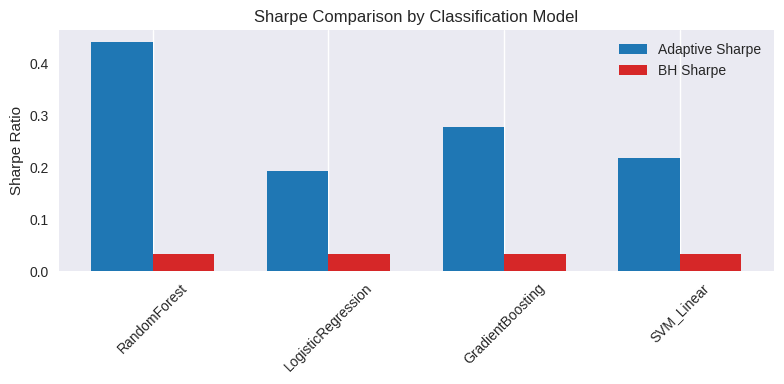

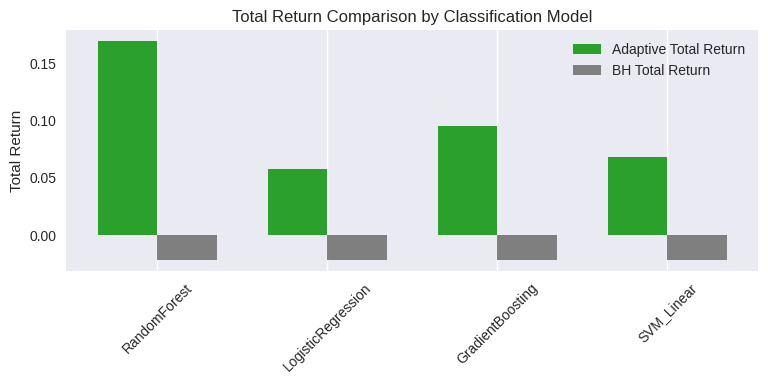

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# =============================================================================
# COMPARE DIFFERENT CLASSIFIERS FOR REGIME PREDICTION
# (Using GMM with 5 clusters; train on first 2500 → test on remaining)
# =============================================================================

# 1) LOAD & CLEAN DATA
file_path = 'Project_RAMA2.xlsx'
df_raw = pd.read_excel(file_path, sheet_name='Processed2')

# Drop any column that is entirely NaN
df = df_raw.dropna(axis=1, how='all').copy()

# Sort by date ascending
df = df.sort_values('date').reset_index(drop=True)

# Compute next-day SX5E return (decimal)
df['next_return'] = df['sx5e_move'].shift(-1) / 100.0

# Drop the final row (no next_return)
df = df.dropna(subset=['next_return']).reset_index(drop=True)

# (Optional) Reconstruct price index for reference
df['price'] = np.nan
df.loc[0, 'price'] = 100.0
for i in range(1, len(df)):
    df.loc[i, 'price'] = df.loc[i-1, 'price'] * (1 + df.loc[i-1, 'next_return'])

# 2) PREPARE EXPLANATORY FEATURES
exclude_cols = ['date', 'target', 'next_return', 'price', 'sx5e_move']
feature_cols = [c for c in df.columns if c not in exclude_cols]

# Drop rows with any NaNs in explanatory features
df_feat = df.dropna(subset=feature_cols).reset_index(drop=True)

# 3) SPLIT INTO TRAIN (first 2500) AND TEST (remaining)
train_size = 2500
if df_feat.shape[0] < train_size + 1:
    raise ValueError("Not enough rows (after dropping NaNs) to split 2500 train + test.")

train_df = df_feat.iloc[:train_size].reset_index(drop=True)
test_df  = df_feat.iloc[train_size:].reset_index(drop=True)

# 4) SCALE FEATURES BASED ON TRAIN
scaler = StandardScaler().fit(train_df[feature_cols])
X_train = scaler.transform(train_df[feature_cols])
X_test  = scaler.transform(test_df[feature_cols])

# 5) FIT GMM WITH 3 COMPONENTS ON TRAIN → DEFINE REGIMES
n_regimes = 3
gmm = GaussianMixture(n_components=n_regimes, covariance_type='full', random_state=42)
gmm.fit(X_train)

train_df['regime'] = gmm.predict(X_train)
test_df['regime_gmm'] = gmm.predict(X_test)

# Rank regimes by average next_return on train (0=best, 4=worst)
regime_stats = train_df.groupby('regime')['next_return'].mean().rename('AvgNextReturn')
regime_order = regime_stats.sort_values(ascending=False).index.tolist()
regime_rank_map = {regime: rank for rank, regime in enumerate(regime_order)}

train_df['regime_rank'] = train_df['regime'].map(regime_rank_map)
test_df['regime_rank_gmm'] = test_df['regime_gmm'].map(regime_rank_map)

# 6) DEFINE CLASSIFIERS TO COMPARE
classifiers = {
    'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42),
    'LogisticRegression': LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'SVM_Linear': SVC(kernel='linear', C=1.0, probability=True, random_state=42)
}

# 7) PERFORMANCE METRICS FUNCTION
def compute_metrics(pnl_series):
    daily_ret = pnl_series / 10_000_000
    wealth = (1 + daily_ret).cumprod()
    total_ret = wealth.iloc[-1] - 1
    avg_dr = daily_ret.mean()
    std_dr = daily_ret.std(ddof=1)
    ann_ret = avg_dr * 252
    ann_vol = std_dr * np.sqrt(252)
    sharpe = (avg_dr / std_dr) * np.sqrt(252) if std_dr != 0 else np.nan
    running_max = wealth.cummax()
    drawdown = wealth / running_max - 1
    max_dd = drawdown.min()
    return total_ret, ann_ret, ann_vol, sharpe, max_dd

# 8) LOOP OVER EACH CLASSIFIER
results = []

for name, clf in classifiers.items():
    # Train to predict GMM labels on train
    clf.fit(X_train, train_df['regime'])
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(train_df['regime'], train_pred)

    # Predict regimes on test
    test_df['regime_pred'] = clf.predict(X_test)
    test_df['regime_rank_pred'] = test_df['regime_pred'].map(regime_rank_map)


    test_df['prev_return'] = test_df['next_return'].shift(1).fillna(0)
    signals = np.zeros(len(test_df), dtype=int)
    for i in range(len(test_df)):
        r = test_df.loc[i, 'regime_rank_pred']
        if r < 1:
            signals[i] = 1
        elif r >= 2:
            signals[i] = -1
        else:
            signals[i] = 0
    test_df['signal'] = signals

    # Compute PnL for adaptive strategy
    test_df['position'] = test_df['signal'] * 10_000_000
    test_df['pnl_adaptive'] = test_df['position'] * test_df['next_return']
    test_df['cum_pnl_adaptive'] = test_df['pnl_adaptive'].cumsum()

    # Compute PnL for buy-and-hold baseline
    test_df['pnl_bh'] = 10_000_000 * test_df['next_return']
    test_df['cum_pnl_bh'] = test_df['pnl_bh'].cumsum()

    # Calculate performance metrics
    a_total, a_ann, a_vol, a_sharpe, a_dd = compute_metrics(test_df['pnl_adaptive'])
    bh_total, bh_ann, bh_vol, bh_sharpe, bh_dd = compute_metrics(test_df['pnl_bh'])

    results.append({
        'Model': name,
        'TrainAccuracy': train_acc,
        'AdaptiveTotalReturn': a_total,
        'AdaptiveAnnReturn': a_ann,
        'AdaptiveAnnVol': a_vol,
        'AdaptiveSharpe': a_sharpe,
        'AdaptiveMaxDD': a_dd,
        'BHTotalReturn': bh_total,
        'BHAnnReturn': bh_ann,
        'BHAnnVol': bh_vol,
        'BHSharpe': bh_sharpe,
        'BHMaxDD': bh_dd
    })

# 9) DISPLAY RESULTS TABLE
metrics_df = pd.DataFrame(results).set_index('Model')
print("=== Performance Comparison Across Classification Models ===")
display(metrics_df.style.format({
    'TrainAccuracy': '{:.4f}',
    'AdaptiveTotalReturn': '{:.4f}',
    'AdaptiveAnnReturn': '{:.4f}',
    'AdaptiveAnnVol': '{:.4f}',
    'AdaptiveSharpe': '{:.4f}',
    'AdaptiveMaxDD': '{:.4f}',
    'BHTotalReturn': '{:.4f}',
    'BHAnnReturn': '{:.4f}',
    'BHAnnVol': '{:.4f}',
    'BHSharpe': '{:.4f}',
    'BHMaxDD': '{:.4f}'
}))

# 10) PLOT SHARPE RATIOS FOR EACH MODEL (Adaptive vs BH)
plt.figure(figsize=(8, 4))
idx = np.arange(len(metrics_df))
width = 0.35
plt.bar(idx - width/2, metrics_df['AdaptiveSharpe'].astype(float), width, label='Adaptive Sharpe', color='tab:blue')
plt.bar(idx + width/2, metrics_df['BHSharpe'].astype(float), width, label='BH Sharpe', color='tab:red')
plt.xticks(idx, metrics_df.index, rotation=45)
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Comparison by Classification Model')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 11) PLOT TOTAL RETURN FOR EACH MODEL (Adaptive vs BH)
plt.figure(figsize=(8, 4))
plt.bar(idx - width/2, metrics_df['AdaptiveTotalReturn'].astype(float), width, label='Adaptive Total Return', color='tab:green')
plt.bar(idx + width/2, metrics_df['BHTotalReturn'].astype(float), width, label='BH Total Return', color='tab:gray')
plt.xticks(idx, metrics_df.index, rotation=45)
plt.ylabel('Total Return')
plt.title('Total Return Comparison by Classification Model')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
